<a href="https://colab.research.google.com/github/meriemdouider1/final-dl-code/blob/main/resnet%20v2%20%20finalf(data%201)%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation des packages :

In [ ]:
import json
import math
import os
import cv2
import numpy as np
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline
from glob import glob
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model



Tout d'abord, récupérons l'ensemble de données Glaucoma Positive contre Glaucoma négative en utilisant kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle (4).json


{'kaggle.json': b'{"username":"meryemdouider","key":"71abdf1b37f401d9b4f539d2b43177eb"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download "sshikamaru/glaucoma-detection"

kaggle.json
glaucoma-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip glaucoma-detection.zip

Archive:  glaucoma-detection.zip
replace Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/001.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/002.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/003.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/004.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/005.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/006.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/007.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/008.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/009.jpg  
  inflating: Fundus_Train_Val_Dat

Préparation des données entraînement /test / validation :

In [ ]:
DATAGlua_Train = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'
DATAGlua_Test = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'


notre jeu deux de données est divisé en deux partie :

1.   des données avec un Gluacoma_positive
2.   des données avec un Gluacoma_négative



In [ ]:
CATEGORIES  = list()
for root, dirs, files in os.walk(DATAGlua_Train, topdown=False):
    for name in dirs:
        CATEGORIES.append(os.path.join(name))
print (CATEGORIES)

['Glaucoma_Positive', 'Glaucoma_Negative']


Division l'ensemble de données d'entraînement en x_train_data et y_train_data : (x_train_data : 'les images' , y_train_data : 'label / catégorie ')

In [ ]:
x_train_data = []
y_train_data = []
IMG_SIZE=224
def creation_train_data():
    for category in CATEGORIES:
      path = os.path.join(DATAGlua_Train, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_train_data.append(new_array)
            y_train_data.append(class_num)
        except Exception as e:
            pass
creation_train_data()

In [ ]:
x_test_data = []
y_test_data = []
IMG_SIZE=224
def creation_test_data():
    for category in CATEGORIES:
      path = os.path.join(DATAGlua_Test, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_test_data.append(new_array)
            y_test_data.append(class_num)
        except Exception as e:
            pass
creation_test_data ()

In [ ]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(x_train_data, y_train_data, test_size=0.05, random_state=1)

In [ ]:
X_Train = np. squeeze(np.array(X_Train))
X_Val = np. squeeze(np.array(X_Val))
Y_Train = np. squeeze(np.array(Y_Train))
Y_Val = np. squeeze(np.array(Y_Val))
x_test_data = np. squeeze(np.array(x_test_data))

In [ ]:
Y_Train = to_categorical(Y_Train)
Y_Val = to_categorical(Y_Val)

# **Transfer learning**

# Création du modèle:

# **inception_resnet_v2**


Inception-ResNet-v2 est une architecture neuronale convolutionnelle qui s'appuie sur la famille d'architectures Inception . nception-ResNet-v2 est un réseau neuronal est formé sur plus d'un million d'images de la base de données ImageNet . Le réseau comprend plusieurs couches de profondeur et peut classer les images en 1000 catégories d'objets .
https://keras.io/api/applications/inceptionresnetv2/
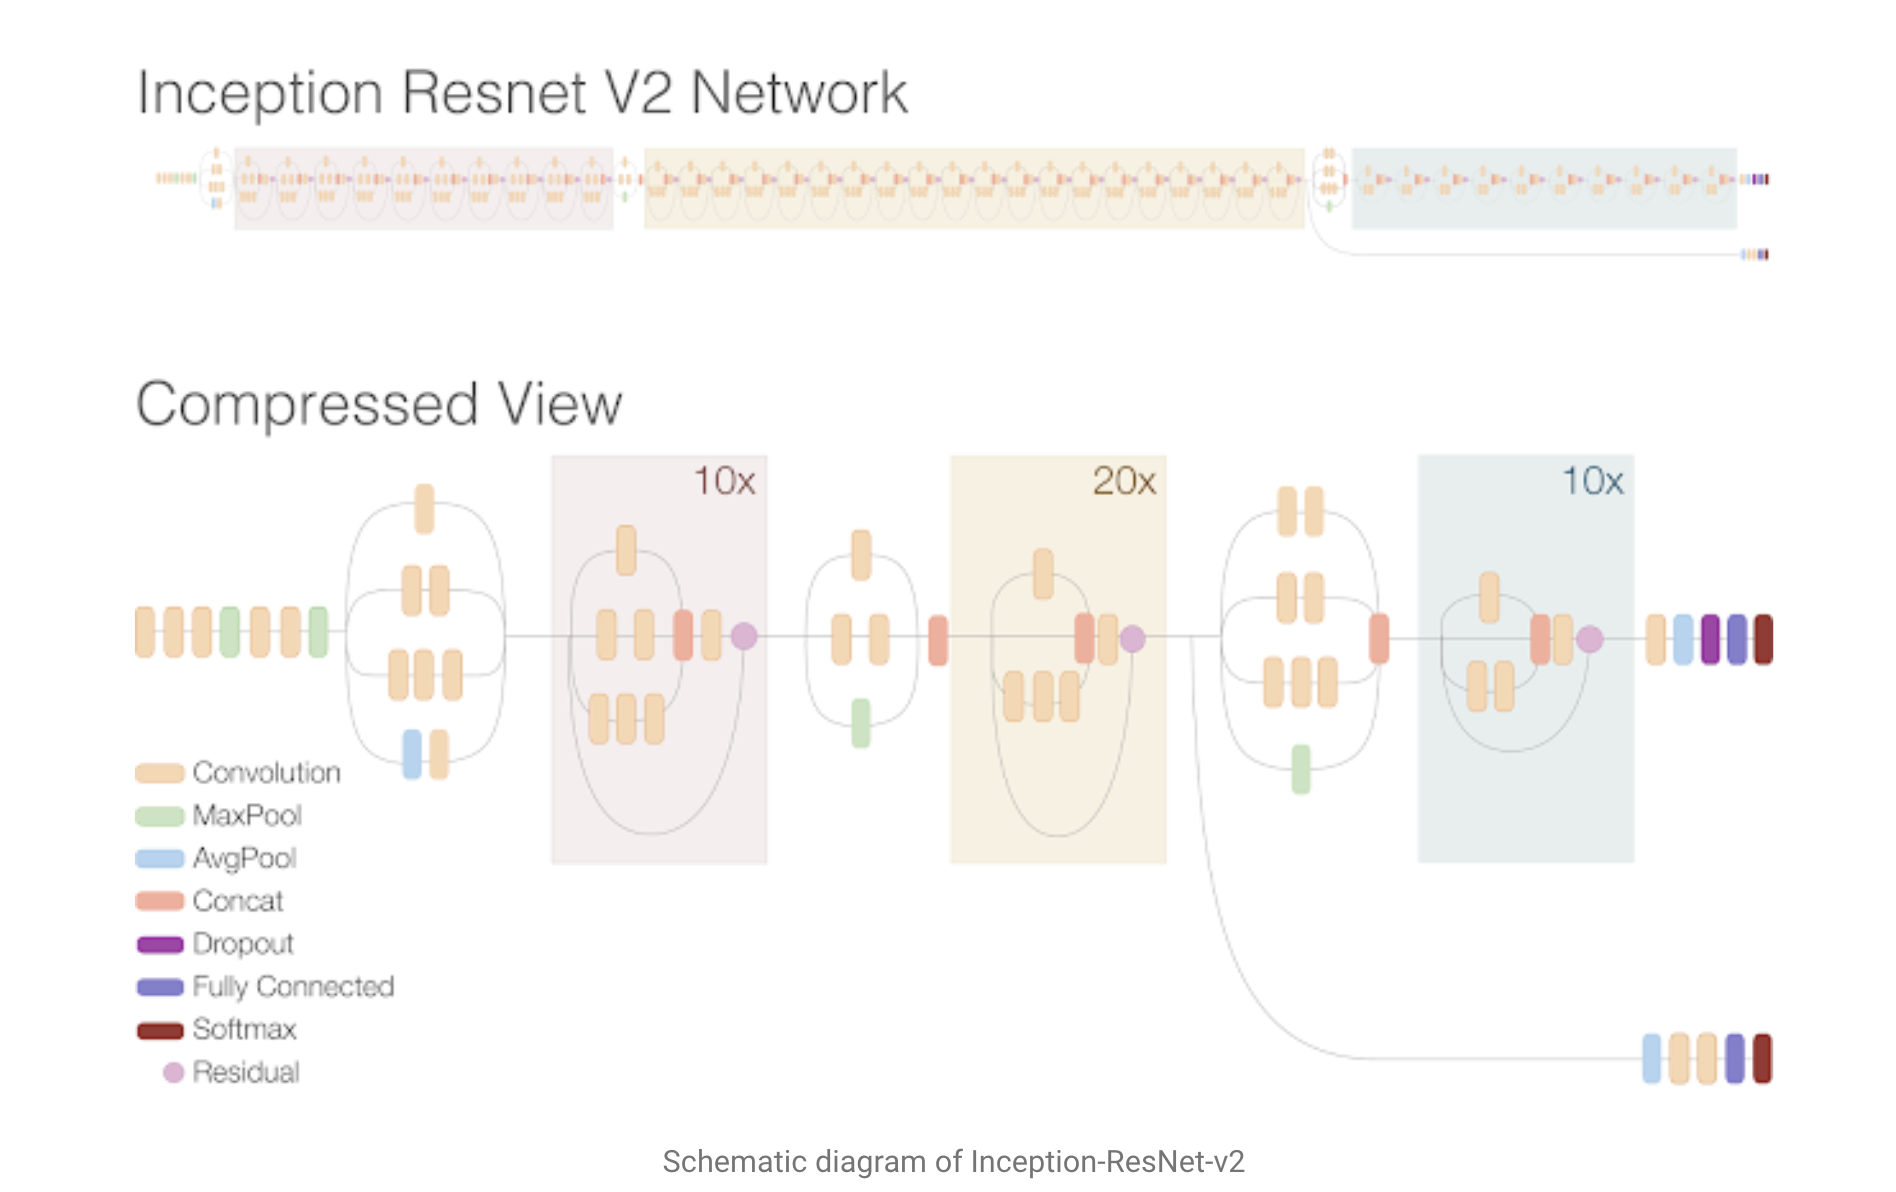

In [ ]:
IMG_SHAPE = (224, 224,3)

importer le modèle pré-entraîne inception_resnet_v2:

In [ ]:
from tensorflow.keras.applications import inception_resnet_v2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten

In [ ]:
base_model3 = inception_resnet_v2.InceptionResNetV2

base_model3 = base_model3(weights='imagenet', include_top=False)

affichage les layer du modèle resnet-v2 et Figer le modèle pré-entraine en utilisant la commande layer.trainable = False

In [ ]:
for layer in base_model3.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(base_model3.layers))

input_5
conv2d_812
batch_normalization_812
activation_812
conv2d_813
batch_normalization_813
activation_813
conv2d_814
batch_normalization_814
activation_814
max_pooling2d_16
conv2d_815
batch_normalization_815
activation_815
conv2d_816
batch_normalization_816
activation_816
max_pooling2d_17
conv2d_820
batch_normalization_820
activation_820
conv2d_818
conv2d_821
batch_normalization_818
batch_normalization_821
activation_818
activation_821
average_pooling2d_4
conv2d_817
conv2d_819
conv2d_822
conv2d_823
batch_normalization_817
batch_normalization_819
batch_normalization_822
batch_normalization_823
activation_817
activation_819
activation_822
activation_823
mixed_5b
conv2d_827
batch_normalization_827
activation_827
conv2d_825
conv2d_828
batch_normalization_825
batch_normalization_828
activation_825
activation_828
conv2d_824
conv2d_826
conv2d_829
batch_normalization_824
batch_normalization_826
batch_normalization_829
activation_824
activation_826
activation_829
block35_1_mixed
block35_1_con

In [ ]:
base_model3.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_812 (Conv2D)             (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_812 (BatchN (None, None, None, 3 96          conv2d_812[0][0]                 
__________________________________________________________________________________________________
activation_812 (Activation)     (None, None, None, 3 0           batch_normalization_812[0][0]    
________________________________________________________________________________


Création d'un nouveau modèle qui va se baser sur les résultas du modèle pré-entraîne :

nous utilisons plusieurs layer : Global MaxPooling2d / dense  , et comme un optimizer nous avons testé plusieurs optimizer (sgd /adam ) , mais l'optimizer qui a donnée le meilleur résultat est le sgd

In [ ]:
x = base_model3.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(2, activation='sigmoid')(x)


model3 = Model(base_model3.input, x)
optimizer = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:

model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_812 (Conv2D)             (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_812 (BatchN (None, None, None, 3 96          conv2d_812[0][0]                 
__________________________________________________________________________________________________
activation_812 (Activation)     (None, None, None, 3 0           batch_normalization_812[0][0]    
____________________________________________________________________________________________


une étape importante avant d'entrainer le modèle est la normalisation pour mettre à l'échelle les valeurs d'entrée (initialement dans la plage [0, 255]) à la plage [0, 1]. cette normalisation est effectuée en utilisant la fonction ImageDataGenerator . catte fonction va nous permis de normaliser les données d'entrée test et validation. cette fonction est utilisable aussi pour l'augmentation des données .



In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

Augmentation et normalisation du données test :

In [ ]:
train_datagen.fit(X_Train)


normalisation du données de validation :

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen.fit(X_Val)

Entraînement du modèle avec des layers du modèle pré-entrâine ( en mode freeze)

In [ ]:
train_model  = model3.fit(X_Train, Y_Train, batch_size=64, epochs=10,
                    validation_data=(X_Val, Y_Val))

Epoch 1/10
8/8 [==============================] - 14s 722ms/step - loss: 81176.7851 - accuracy: 0.5218 - val_loss: 0.6966 - val_accuracy: 0.8077
Epoch 2/10
8/8 [==============================] - 3s 320ms/step - loss: 0.7345 - accuracy: 0.6336 - val_loss: 0.6915 - val_accuracy: 0.8462
Epoch 3/10
8/8 [==============================] - 3s 324ms/step - loss: 0.6920 - accuracy: 0.7214 - val_loss: 0.6903 - val_accuracy: 0.8462
Epoch 4/10
8/8 [==============================] - 3s 326ms/step - loss: 0.6909 - accuracy: 0.7446 - val_loss: 0.6890 - val_accuracy: 0.8462
Epoch 5/10
8/8 [==============================] - 3s 325ms/step - loss: 0.6899 - accuracy: 0.7564 - val_loss: 0.6877 - val_accuracy: 0.8462
Epoch 6/10
8/8 [==============================] - 3s 329ms/step - loss: 0.6889 - accuracy: 0.7576 - val_loss: 0.6865 - val_accuracy: 0.8462
Epoch 7/10
8/8 [==============================] - 3s 330ms/step - loss: 0.6884 - accuracy: 0.7352 - val_loss: 0.6852 - val_accuracy: 0.8462
Epoch 8/10
8/8 

# fine-tuning

dégelons maintenant le modèle de base et formons l'ensemble du modèle de bout en bout avec un faible taux d'apprentissage.

Il est important de noter que bien que le modèle de base devienne entraînable, il fonctionne toujours en mode inférence puisque nous avons passé training = False lors de son appel lorsque nous avons construit le modèle.

In [ ]:
for layer in model3.layers :
   layer.trainable = True
 

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_812 (Conv2D)             (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_812 (BatchN (None, None, None, 3 96          conv2d_812[0][0]                 
__________________________________________________________________________________________________
activation_812 (Activation)     (None, None, None, 3 0           batch_normalization_812[0][0]    
____________________________________________________________________________________________

In [ ]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [ ]:
train_model  = model3.fit(X_Train, Y_Train, batch_size=64, epochs=10,
                    validation_data=(X_Val, Y_Val))

Epoch 1/10
8/8 [==============================] - 27s 2s/step - loss: 0.7312 - acc: 0.2601 - val_loss: 1.1403 - val_acc: 0.1538
Epoch 2/10
8/8 [==============================] - 9s 1s/step - loss: 0.7176 - acc: 0.3099 - val_loss: 0.8096 - val_acc: 0.1538
Epoch 3/10
8/8 [==============================] - 9s 1s/step - loss: 0.6978 - acc: 0.4847 - val_loss: 0.6954 - val_acc: 0.4615
Epoch 4/10
8/8 [==============================] - 9s 1s/step - loss: 0.6796 - acc: 0.6359 - val_loss: 0.6397 - val_acc: 0.6923
Epoch 5/10
8/8 [==============================] - 9s 1s/step - loss: 0.6657 - acc: 0.7299 - val_loss: 0.6051 - val_acc: 0.7308
Epoch 6/10
8/8 [==============================] - 9s 1s/step - loss: 0.6509 - acc: 0.7326 - val_loss: 0.5733 - val_acc: 0.8462
Epoch 7/10
8/8 [==============================] - 8s 1s/step - loss: 0.6287 - acc: 0.7554 - val_loss: 0.5455 - val_acc: 0.8462
Epoch 8/10
8/8 [==============================] - 8s 1s/step - loss: 0.6168 - acc: 0.7623 - val_loss: 0.5273 -

**Test :**

In [ ]:
loss_val, acc_val = model3.evaluate(X_Val, Y_Val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

1/1 [==============================] - 0s 156ms/step - loss: 0.4972 - acc: 0.8462
Validation: accuracy = 0.846154  ;  loss_v = 0.497243


In [ ]:
y_test_data = to_categorical(y_test_data)
loss_test, acc_test = model3.evaluate(x_test_data, y_test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

5/5 [==============================] - 1s 132ms/step - loss: 0.5997 - acc: 0.7385
Test: accuracy = 0.738462  ;  loss = 0.599723


In [ ]:
model3.save("Incep_ResNet_v2.h5")

Text(0.5, 1.0, 'Training and validation loss')

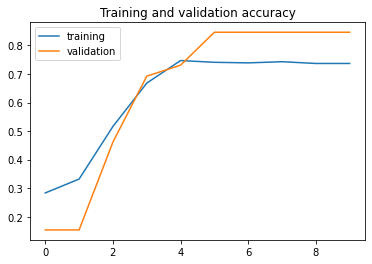

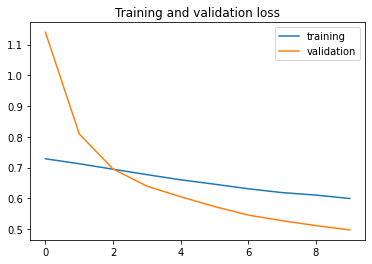

In [ ]:

acc = train_model.history['acc']
val_acc = train_model.history['val_acc']


loss = train_model.history['loss']
val_loss = train_model.history['val_loss']


epochs = range(len(acc))


plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')